# Serie A - Differenziale xG


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

from PIL import Image
import urllib
import os
import math

In [6]:
font_path = "assets/fonts/"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("assets/stylesheets/soc_base.mplstyle")

## Leggere il dataframe

In [7]:
df = pd.read_csv('data/xG_minus_xGA.csv', index_col=0)
df = df.sort_values(by='xG-xGA').reset_index(drop=True)

df

,team_id,Squad,xG,xGA,xG-xGA
0,6480,Salernitana,31.0,55.7,-24.6
1,9882,Sampdoria,27.8,51.3,-23.5
2,7801,Cremonese,32.6,55.3,-22.7
3,9881,Spezia,34.8,53.2,-18.5
4,8534,Empoli,29.9,48.1,-18.2
5,9876,Hellas Verona,30.2,39.3,-9.1
6,9857,Bologna,33.4,39.5,-6.1
7,9888,Lecce,29.3,34.9,-5.6
8,6504,Monza,39.0,41.4,-2.4
9,8600,Udinese,41.7,43.8,-2.1


## Visualizzazione

Bar chart orizzontale

<BarContainer object of 20 artists>

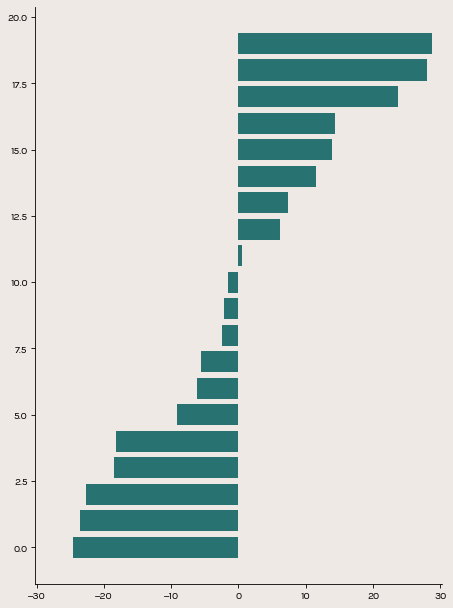

In [8]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 5% margin of that limit to the x-axis
max_ = max_*(1.05)
ax.set_xlim(-max_, max_)

ax.barh(df.index, df['xG-xGA'])

To make our viz more stylish, we perform the following steps:
* Rimuovo l'asse a lato.
* Aggiungo le gridlines.
* Linea in mezzo

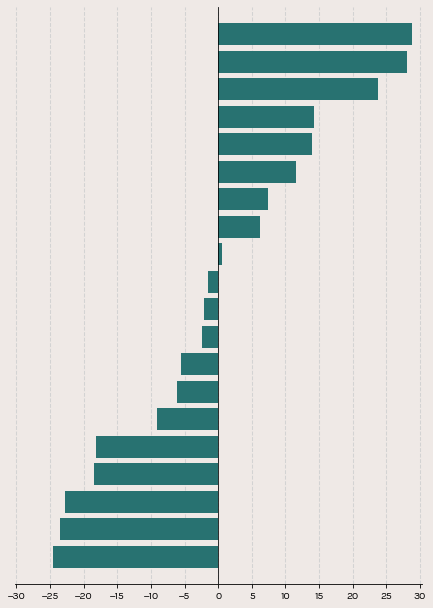

In [24]:
fig = plt.figure(figsize=(7,10), dpi=75)

ax.barh(df.index, df['xG-xGA'])
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 5% margin of that limit to the x-axis
max_ = max_*(1.05)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# -- Bar Chart -------------------------------------
ax.barh(
    df.index, df['xG-xGA'],
    #hatch='//////', ec='#efe9e6',
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)

Ora, scriviamo il differenziale xG nel barchart.

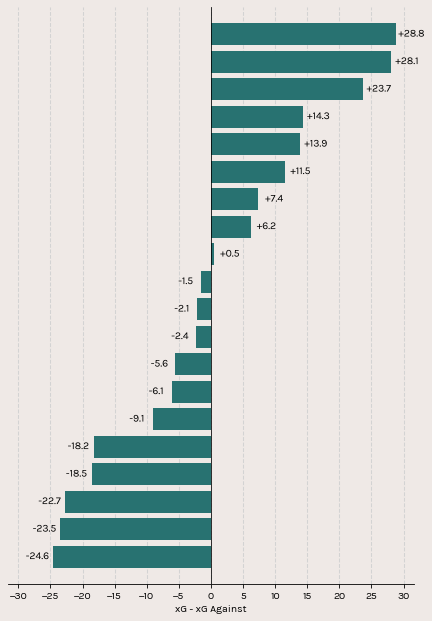

In [32]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('xG - xG Against', size=10)
# -- Bar Chart -------------------------------------
ax.barh(
    df.index, df['xG-xGA'],
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
for index, x in enumerate(df['xG-xGA']):
    if x < 0:
        sign_offset = -1
        sign_text = ''
    else:
        sign_offset = 1
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*15,0),
        text=f'{sign_text}{x:.1f}',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])

### Aggiungo i loghi

Aggiungo i loghi per estetica

In [13]:
# Codici dei loghi, inseriti nel CSV
team_logos = [
    8524, 9857, 7801, 8534,
    8535, 8636, 9885, 8543,
    9888, 8564, 6504, 9875,
    8686, 6480, 9882, 7943,
    9881, 9804, 8600, 9876
]

In [27]:
def add_logo_on_ax(ax, team_id, bw = False):
    '''
    This function adds the logo of a football team on a specific
    axes based on the Fotmob team ID.
    Args:
        - ax (object): the matplotlib axes object.
        - team_id (int): the Fotmob team ID.
        - bw (bool): whether to add the logo as black & white or with color.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))

    if bw:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis("off")
    return ax

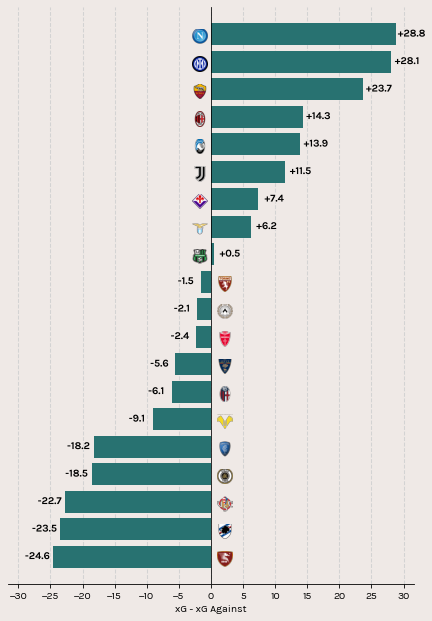

In [43]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('xG - xG Against', size=10)
# -- Bar Chart -------------------------------------
ax.barh(
    df.index, df['xG-xGA'],
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(df['xG-xGA']):
    if x < 0:
        sign_offset = -1
        offset_logo = 1.0
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = 3.0
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*15,0),
        text=f'{sign_text}{x:.1f}',
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    # -- Add the logo
    team_id = df['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo, index - 0.5])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = "C")
    add_logo_on_ax(logo_ax, team_id, False)

### Aggiungo un gradiente per le barre

In [29]:
'''
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]

'''
gradient = [
'#cb0000',
'#da2908',
'#d75609',
'#d88300',
'#d2a900',
'#cbc000',
'#899f84',
'#02ac02',
'#029733',
'#00a589',
'#01a6c3',
'#1878cf',
'#146cf6'
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

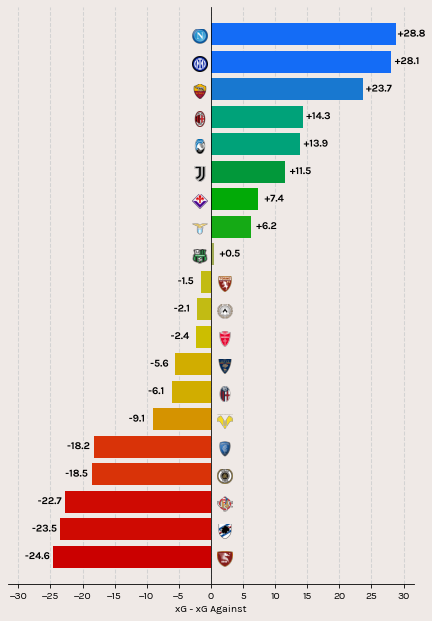

In [44]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('xG - xG Against', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=df['xG-xGA'].min(),vmax=df['xG-xGA'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    df.index, df['xG-xGA'],
    color = cmap(norm(df['xG-xGA'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(df['xG-xGA']):
    if x < 0:
        sign_offset = -1
        offset_logo = 1.0
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = 3.0
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*15,0),
        text=f'{sign_text}{x:.1f}',
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    # -- Add the logo
    team_id = df['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo, index - 0.5])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = "C")
    add_logo_on_ax(logo_ax, team_id)

### Aggiustamenti finali

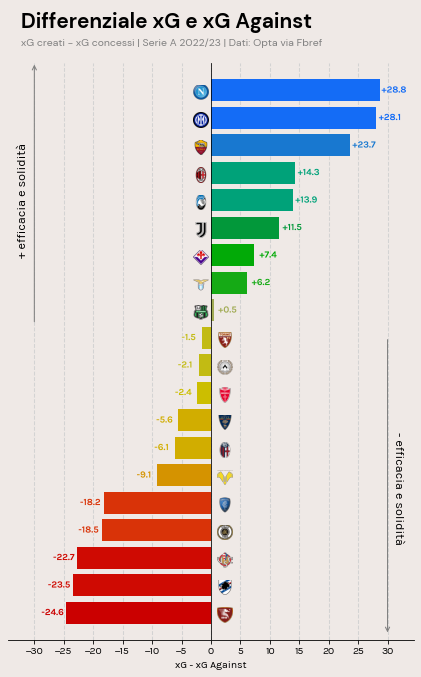

In [53]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
plt.rcParams['hatch.linewidth'] = 0.35
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['xG-xGA'].min()), df['xG-xGA'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.2)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('xG - xG Against', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=df['xG-xGA'].min(),vmax=df['xG-xGA'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    df.index, df['xG-xGA'],
    color = cmap(norm(df['xG-xGA'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(df['xG-xGA']):
    if x < 0:
        sign_offset = -1
        offset_logo = 1.0
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = 3.0
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*13,0),
        text=f'{sign_text}{x:.1f}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    # -- Add the logo
    team_id = df['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo, index - 0.5])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = "C")
    add_logo_on_ax(logo_ax, team_id)

# -- Figure title and arrows --------------------------------
position_negative = df[df['xG-xGA'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2
ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='+ efficacia e solidità',
    rotation=90,
    xytext=(-10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='- efficacia e solidità',
    rotation=-90,
    xytext=(10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

fig_text(
    x = 0.15, y = .92, 
    s = 'Differenziale xG e xG Against',
    va = 'bottom', ha = 'left',
    fontsize = 20, color = 'black', fontname="DM Sans", weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = 'xG creati - xG concessi | Serie A 2022/23 | Dati: Opta via Fbref',
    va = 'bottom', ha = 'left',
    fontsize = 10, font = 'DM Sans', color = 'gray'
)

plt.savefig(
	"figures/SerieA_xG_Differential.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/SerieA_xG_Differential_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)